<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/Random_Forest_Queens_Base_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Case for Prophet data on New York City

## Imports

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np

## Load Data and Preprocessing

### September 14th Data (with growth label)

#### Load Data

In [15]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data'

CA_Covid-19.csv
CA-CovidAug22.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv


In [16]:
NY_labeledData_Aug27 = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Sep13.csv',low_memory=False)
print(NY_labeledData_Aug27.shape)

(9690, 19)


#### Preprocessing 

Total Days: 172

30% Reduction: 120 Days

Days Difference: 52 Days

In [17]:
NY_labeledData_Aug27 = NY_labeledData_Aug27.astype({'label': 'string'})

In [18]:
NY_labeledData_Aug27 = NY_labeledData_Aug27.dropna()

In [59]:
NY_labeledData_Aug27['label_y'] = preprocessing.LabelEncoder().fit_transform(NY_labeledData_Aug27['label'])

In [60]:
NY_labeledData_Aug27['label_y'].unique()

array([0, 2, 1])

In [20]:
NY_labeledData_Aug27.rename(columns={'Date': 'ds', 'label_y': 'y'}, inplace=True)

In [21]:
mask = (NY_labeledData_Aug27['ds'] > '2020-03-01') & (NY_labeledData_Aug27['ds'] <= '2020-06-29')
NY_labeledData_70 = NY_labeledData_Aug27.loc[mask]
NY_labeledData_70.tail()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
6778,2020-06-29,36057,Montgomery County,-12.0,13.0,0.0,0.0,-31.0,8.0,65.94,4.168,66,122.124355,1,0.749,0,1.428571,LessSpread,mild_growth,0
6779,2020-06-29,36119,Westchester County,-18.0,-6.0,63.0,-43.0,-45.0,15.0,21.57,2.392,36,2247.400697,1,0.798,18,34.428571,LessSpread,mild_decrement,0
6780,2020-06-29,36017,Chenango County,1.0,19.0,0.0,0.0,-36.0,8.0,92.97,3.845,50,52.830843,1,0.735,0,0.857143,LessSpread,mild_decrement,0
6781,2020-06-29,36063,Niagara County,-9.0,17.0,200.0,-24.0,-33.0,7.0,64.40,3.074,47,400.645149,1,0.730,2,5.000000,LessSpread,mild_growth,0
6782,2020-06-29,36015,Chemung County,-10.0,11.0,0.0,-43.0,-26.0,7.0,71.85,2.889,49,204.875414,1,0.594,0,0.142857,LessSpread,mild_growth,0


In [22]:
NY_labeledData_70_Ulster_County = NY_labeledData_70.loc[NY_labeledData_70['County Name'] == 'Ulster County']
NY_labeledData_Ulster_County = NY_labeledData_Aug27.loc[NY_labeledData_Aug27['County Name'] == 'Ulster County']

In [23]:
NY_labeledData_70_Ulster_County['y'].unique()

array([0])

In [24]:
NY_labeledData_Aug27.head()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,LessSpread,flat_growth,0
1,2020-03-01,36003,Allegany County,47.0,13.0,0.0,0.0,1.0,0.0,19.81,0.707,12,44.778541,0,0.0,0,0.0,LessSpread,flat_growth,0
2,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,LessSpread,flat_growth,0
3,2020-03-01,36119,Westchester County,8.0,-1.0,12.0,1.0,0.0,0.0,-4.34,3.903,59,2247.400697,0,0.0,0,0.0,LessSpread,flat_growth,0
4,2020-03-01,36031,Essex County,16.0,11.0,17.0,0.0,1.0,0.0,60.18,12.600,197,20.557565,0,0.0,0,0.0,LessSpread,flat_growth,0


In [25]:
NY_labeledData_70_Ulster_County.tail()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
6535,2020-06-25,36111,Ulster County,-12.0,10.0,0.0,6.0,-31.0,10.0,64.96,5.563,85,157.94937,1,0.818,5,2.714286,LessSpread,mild_growth,0
6556,2020-06-26,36111,Ulster County,-18.0,5.0,0.0,-8.0,-32.0,10.0,86.42,5.941,90,157.94937,1,0.818,3,2.714286,LessSpread,mild_growth,0
6628,2020-06-27,36111,Ulster County,-23.0,6.0,0.0,9.0,-13.0,6.0,69.99,3.161,48,157.94937,1,0.818,5,3.285714,LessSpread,mild_growth,0
6669,2020-06-28,36111,Ulster County,-18.0,5.0,199.0,6.0,-5.0,4.0,62.63,2.514,38,157.94937,1,0.818,5,3.428571,LessSpread,mild_growth,0
6756,2020-06-29,36111,Ulster County,-10.0,5.0,0.0,-2.0,-31.0,10.0,55.25,3.253,49,157.94937,1,0.818,0,3.142857,LessSpread,mild_growth,0


In [26]:
NY_labeledData_Aug27.tail()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
9685,2020-08-19,36099,Seneca County,0.0,0.0,0.0,0.0,0.0,0.0,162.86,6.632,98,105.081709,1,0.864,0,0.571429,LessSpread,mild_decrement,0
9686,2020-08-19,36023,Cortland County,0.0,0.0,0.0,0.0,0.0,0.0,85.52,3.803,141,95.398588,1,0.803,0,0.142857,LessSpread,mild_decrement,0
9687,2020-08-19,36101,Steuben County,0.0,0.0,0.0,0.0,0.0,0.0,103.47,5.512,88,68.590352,1,0.674,0,1.000000,LessSpread,mild_growth,0
9688,2020-08-19,36103,Suffolk County,0.0,0.0,0.0,0.0,0.0,0.0,60.19,5.039,58,1618.991283,1,0.782,70,51.000000,LessSpread,mild_decrement,0
9689,2020-08-19,36123,Yates County,0.0,0.0,0.0,0.0,0.0,0.0,350.22,6.347,91,73.676584,1,0.884,0,0.285714,LessSpread,mild_growth,0


## Random Forest

In [27]:
le = LabelEncoder()
NY_labeledData_Aug27_encoded = NY_labeledData_Aug27.apply(le.fit_transform)
NY_labeledData_Aug27_encoded.head()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
0,0,0,0,99,73,96,86,87,4,2249,1750,54,47,0,0,14,7,0,2,0
1,0,1,1,136,73,77,82,81,5,3264,537,12,6,0,0,14,7,0,2,0
2,0,56,56,120,93,77,82,87,5,3599,3430,72,16,0,0,14,7,0,2,0
3,0,54,54,97,59,89,83,80,5,2269,2682,59,54,0,0,14,7,0,2,0
4,0,14,14,105,71,94,82,81,5,4864,5341,194,0,0,0,14,7,0,2,0


In [28]:
labels = np.array(NY_labeledData_Aug27_encoded['y'])
features= NY_labeledData_Aug27_encoded.drop(['label','y'], axis = 1)

In [29]:
feature_list = list(features.columns)
features = np.array(features)

In [30]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [31]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7236, 18)
Training Labels Shape: (7236,)
Testing Features Shape: (2412, 18)
Testing Labels Shape: (2412,)


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [33]:
train_features.shape

(7236, 18)

In [34]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [35]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: nan %.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



In [36]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [37]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

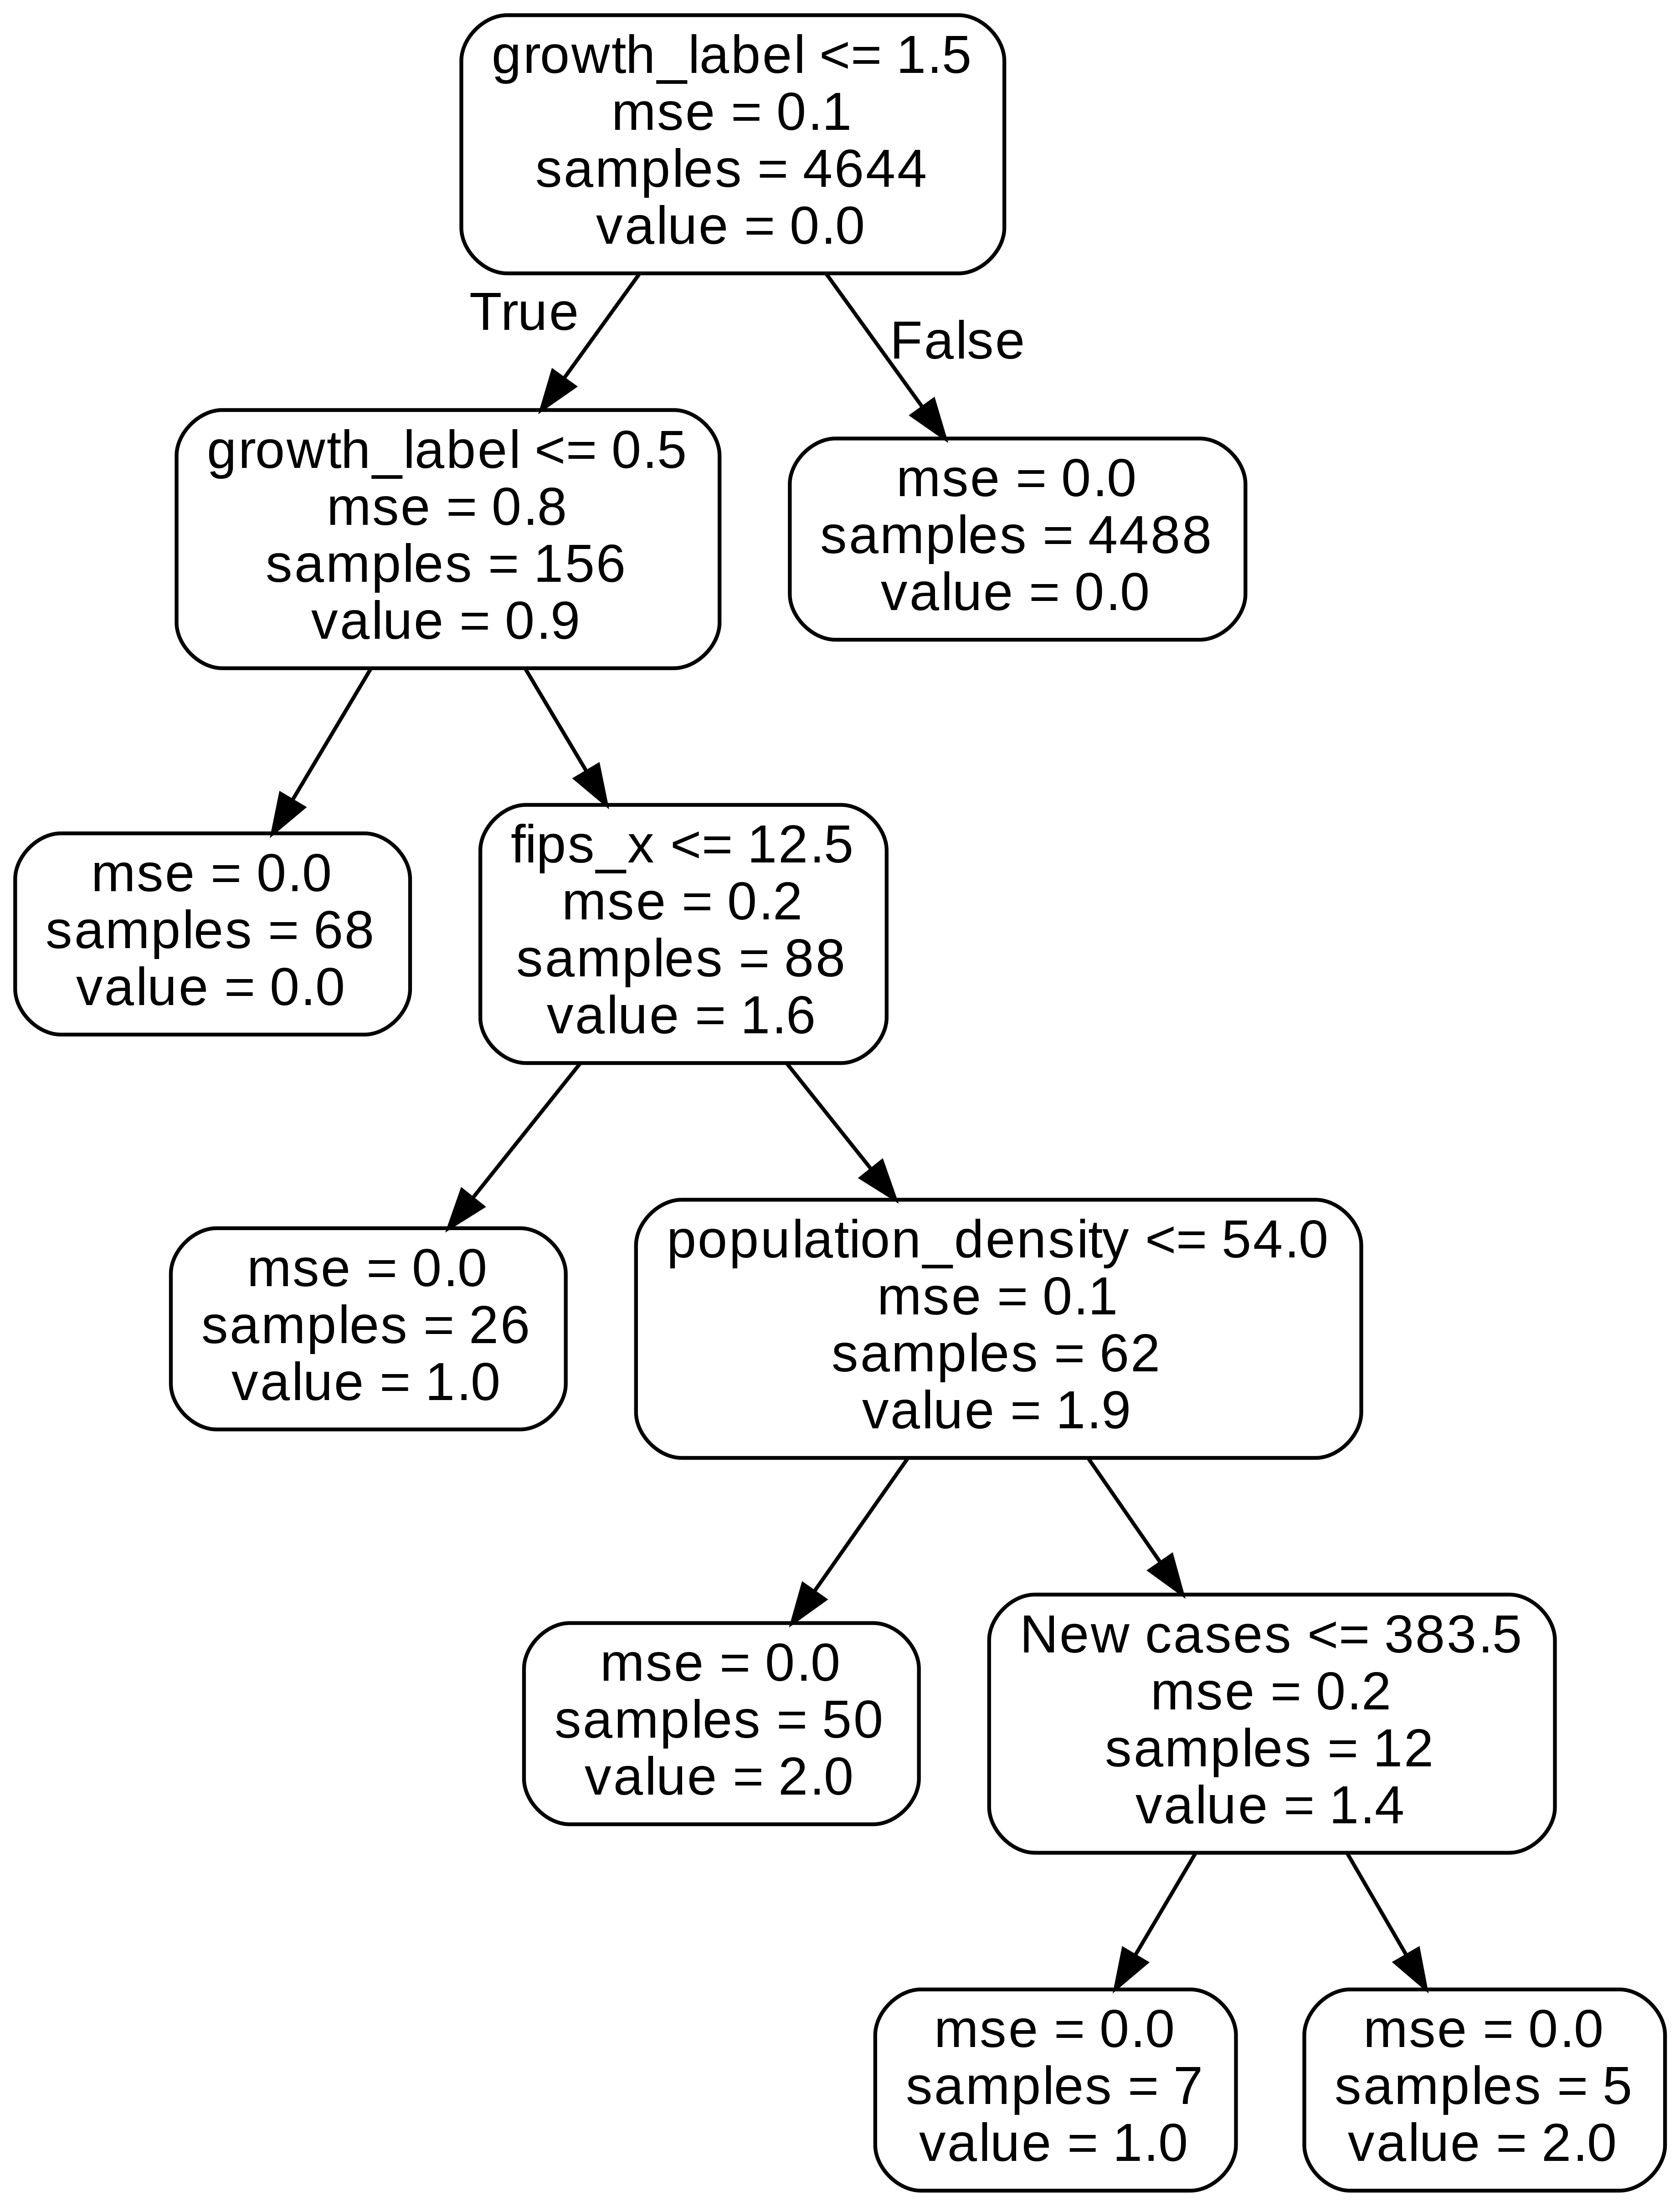

In [38]:
from IPython.display import Image
Image(filename = 'tree.png')

In [39]:
feature_list[0]

'ds'

## Show Feature importance list

In [40]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%d. %s : (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))


Feature ranking:
1. growth_label : (0.919199)
2. fips_x : (0.031032)
3. County Name : (0.028192)
4. population_density : (0.018145)
5. New cases : (0.002009)
6. retail and recreation : (0.001422)
7. workplaces : (0.000000)
8. grocery and pharmacy : (0.000000)
9. parks : (0.000000)
10. transit stations : (0.000000)
11. residential : (0.000000)
12. rolling_avg_new_cases : (0.000000)
13. driving : (0.000000)
14. m50 : (0.000000)
15. m50_index : (0.000000)
16. mask_rule_active : (0.000000)
17. mask_wearing_percent : (0.000000)
18. ds : (0.000000)


## Prophet Model Implementation for August 27rd

In [41]:
prophet_model = Prophet()

In [42]:
prophet_model.fit(NY_labeledData_70_Ulster_County)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = prophet_model.make_future_dataframe(periods=51)

In [44]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
164,2020-08-15,0.0,-1.333042e-08,1.188097e-08
165,2020-08-16,0.0,-1.347928e-08,1.184691e-08
166,2020-08-17,0.0,-1.413739e-08,1.268393e-08
167,2020-08-18,0.0,-1.459396e-08,1.275563e-08
168,2020-08-19,0.0,-1.465524e-08,1.334905e-08


In [45]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
164,2020-08-15,0.0,-1.333042e-08,1.188097e-08,-1.301866e-08,1.149468e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,2020-08-16,0.0,-1.347928e-08,1.184691e-08,-1.344885e-08,1.194403e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,2020-08-17,0.0,-1.413739e-08,1.268393e-08,-1.382446e-08,1.222521e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,2020-08-18,0.0,-1.459396e-08,1.275563e-08,-1.439227e-08,1.270482e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,2020-08-19,0.0,-1.465524e-08,1.334905e-08,-1.497315e-08,1.315919e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
NY_labeledData_Ulster_County.tail()

,ds,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,y
9405,2020-08-15,36111,Ulster County,-4.0,9.0,0.0,37.0,-14.0,1.0,131.12,5.053,77,157.94937,1,0.818,3,4.571429,LessSpread,mild_growth,0
9466,2020-08-16,36111,Ulster County,-4.0,1.0,239.0,24.0,-13.0,2.0,109.20,2.003,30,157.94937,1,0.818,6,4.714286,LessSpread,mild_growth,0
9568,2020-08-17,36111,Ulster County,-4.0,1.0,0.0,20.0,-34.0,8.0,78.11,4.048,62,157.94937,1,0.818,3,3.714286,LessSpread,mild_growth,0
9632,2020-08-18,36111,Ulster County,0.0,0.0,0.0,0.0,0.0,0.0,87.84,4.134,63,157.94937,1,0.818,2,3.428571,LessSpread,mild_decrement,0
9659,2020-08-19,36111,Ulster County,0.0,0.0,0.0,0.0,0.0,0.0,86.92,4.066,62,157.94937,1,0.818,6,4.142857,LessSpread,mild_decrement,0


In [47]:
NY_labeledData_Ulster_County.shape

(170, 20)

In [48]:
NY_labeledData_70_Ulster_County.shape

(118, 20)

In [49]:
future.shape

(169, 1)

### Plot forecast

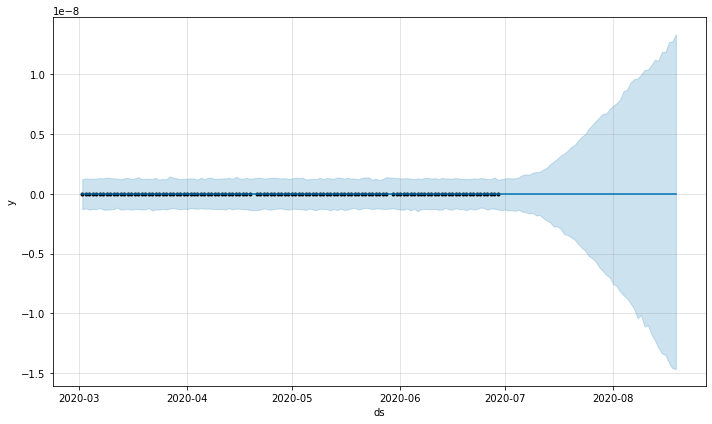

In [50]:
fig1 = prophet_model.plot(forecast)

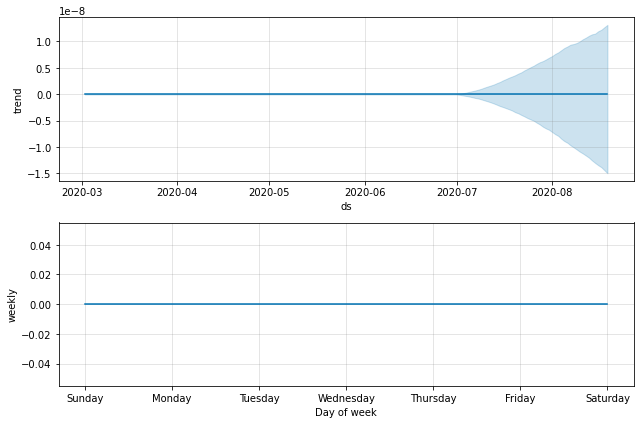

In [51]:
fig2 = prophet_model.plot_components(forecast)

In [52]:
plot_plotly(prophet_model, forecast)

In [53]:
plot_components_plotly(prophet_model, forecast)

### Diagnostics

In [54]:
# 172 total days of data (30%)
df_cv = cross_validation(prophet_model, initial='118 days', period='1 days', horizon = '1 days')
df_cv.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-06-28 00:00:00 and 2020-06-28 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-29,0.0,-1.258480e-09,1.351174e-09,0,2020-06-28


In [55]:
#cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
#df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [56]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days,0.0,0.0,0.0,NaN,1.0


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0


TypeError: ignored

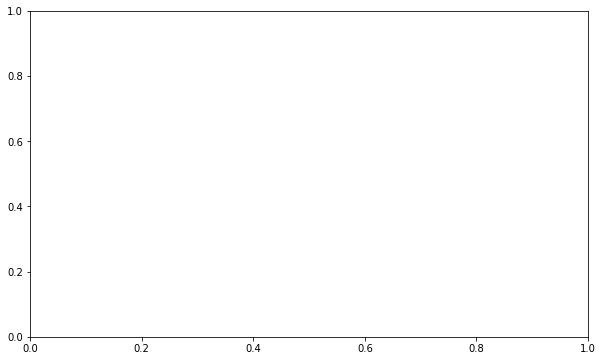

In [57]:
fig = plot_cross_validation_metric(df_cv, metric='mape')